## This notebook can be used to rank a list of nodes from a category that connect to an entity such as a gene. 
#### Example 1: Which disease are associate with NPM1 gene?
#### Example 2: Which proteins interacts with protein NPM1?
#### Example 3: Which drugs or small molecules can interact with NPM1?


In [1]:
import sys
sys.path.append('../TCT')
import TCT as TCT
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import requests

In [2]:
# Step1: List all the APIs in the translator system
Translator_KP_info,APInames= TCT.get_SmartAPI_Translator_KP_info()
Translator_KP_info.to_csv('SmartAPI_Translator_KP_info.csv', index=False)
print(len(Translator_KP_info))

Skipping server without x-maturity: {'description': 'Production server', 'url': 'https://smart-api.info/api'}
Skipping server without x-maturity: {'description': 'Development server', 'url': 'https://dev.smart-api.info/api'}
SmartAPI API
Skipping server without production, staging or testing: {'description': 'Development server', 'url': 'https://dev.smart-api.info/api'}
Skipping server without x-maturity: {'description': 'Staging server', 'url': 'http://biothings.test.transltr.io/annotator'}
Skipping server without x-maturity: {'description': 'CI server', 'url': 'http://biothings.ci.transltr.io/annotator'}
98


In [3]:
# Step 2: Get metaKG and all predicates from Translator APIs
metaKG = TCT.get_KP_metadata(APInames) # This only applies to the Translator APIs  # This need revision because of the metaKG information changes from the SmartAPI team
#print(metaKG.columns)
#metaKG.to_csv('../metaData/metaKG.csv', index=False)
#metaKG = pd.read_csv('../metaData/metaKG.csv')
print(metaKG.shape)
All_predicates = list(set(metaKG['KG_category']))
All_categories = list((set(list(set(metaKG['Subject']))+list(set(metaKG['Object'])))))

(12798, 5)


In [4]:
metaKG

,API,KG_category,Subject,Object,URL
0,BioThings SEMMEDDB API,biolink:affected_by,biolink:PhysiologicalProcess,biolink:SmallMolecule,https://biothings.ncats.io/semmeddb/query/
1,BioThings SEMMEDDB API,biolink:affected_by,biolink:GrossAnatomicalStructure,biolink:SmallMolecule,https://biothings.ncats.io/semmeddb/query/
2,BioThings SEMMEDDB API,biolink:affected_by,biolink:PathologicalProcess,biolink:SmallMolecule,https://biothings.ncats.io/semmeddb/query/
3,BioThings SEMMEDDB API,biolink:affected_by,biolink:Cell,biolink:SmallMolecule,https://biothings.ncats.io/semmeddb/query/
4,BioThings SEMMEDDB API,biolink:interacts_with,biolink:DiagnosticAid,biolink:SmallMolecule,https://biothings.ncats.io/semmeddb/query/
...,...,...,...,...,...
12793,Automat-drug-central(Trapi v1.5.0),biolink:preventative_for_condition,biolink:SmallMolecule,biolink:PhenotypicFeature,https://automat.transltr.io/drugcentral/query/
12794,Automat-drug-central(Trapi v1.5.0),biolink:affects,biolink:ChemicalEntity,biolink:Protein,https://automat.transltr.io/drugcentral/query/
12795,Automat-drug-central(Trapi v1.5.0),biolink:subclass_of,biolink:Disease,biolink:Disease,https://automat.transltr.io/drugcentral/query/
12796,Automat-drug-central(Trapi v1.5.0),biolink:affects,biolink:SmallMolecule,biolink:Protein,https://automat.transltr.io/drugcentral/query/


In [14]:
# Step 3: set input parameters
# Test multiomics BigGIM Drug Response KP
# Node1 for query
input_node1 = 'FLT3'
input_node1_id = TCT.get_curie(input_node1)
print(input_node1_id)
input_node1_list = [input_node1_id]
input_node1_category = ['biolink:Gene'] # Node: this has to be in a format of biolink:xxx

#Node2 for query
input_node2_list = []
input_node2_category = ['biolink:Drug', 'biolink:SmallMolecule', 'biolink:ChemicalSubstance']
#input_node2_category = ['biolink:Gene']

# Get all predicates for the input node1 and node2, user can furter select the predicates among this list
sele_predicates = list(set(TCT.select_concept(sub_list=input_node1_category,
                                              obj_list=input_node2_category,
                                              metaKG=metaKG)))



print("all relevant predicates in Translator:")
print(sele_predicates)
# select predicates

# Get all APIs for the input node1 and node2, user can furter select the APIs among this list
sele_APIs = TCT.select_API(sub_list=input_node1_category,
                           obj_list=input_node2_category,
                           metaKG=metaKG)

print("all relevant APIs in Translator:")
print(sele_APIs)
print(len(sele_APIs))

# get API URLs
API_URLs = TCT.get_Translator_API_URL(sele_APIs, 
                                      APInames)

NCBIGene:2322
all relevant predicates in Translator:
['biolink:associated_with_increased_likelihood_of', 'biolink:coexists_with', 'biolink:similar_to', 'biolink:positively_correlated_with', 'biolink:derives_into', 'biolink:sensitivity_associated_with', 'biolink:resistance_associated_with', 'biolink:affects', 'biolink:part_of', 'biolink:affected_by', 'biolink:interacts_with', 'biolink:output_of', 'biolink:decreases_response_to', 'biolink:correlated_with', 'biolink:affects_response_to', 'biolink:negatively_correlated_with', 'biolink:is_substrate_of', 'biolink:has_part', 'biolink:has_output', 'biolink:directly_physically_interacts_with', 'biolink:occurs_together_in_literature_with', 'biolink:related_to_at_instance_level', 'biolink:associated_with_decreased_likelihood_of', 'biolink:produced_by', 'biolink:response_affected_by', 'biolink:related_to', 'biolink:gene_product_of', 'biolink:associated_with_resistance_to', 'biolink:derives_from', 'biolink:regulates', 'biolink:physically_interacts_

In [ ]:
# can use large language model to select predicates
sele_predicates = ['biolink:associated_with_resistance_to',
                   'biolink:associated_with_sensitivity_to', 
                   'biolink:occurs_together_in_literature_with',
                   'biolink:physically_interacts_with']

In [16]:
# Step 4: Format query json
query_json = TCT.format_query_json(input_node1_list,  # a list of identifiers for input node1
                                   input_node2_list,  # it can be empty list if only want to query node1
                                   input_node1_category,  # a list of categories of input node1
                                   input_node2_category,  # a list of categories of input node2
                                   sele_predicates) # a list of predicates
query_json

{'message': {'query_graph': {'nodes': {'n0': {'ids': ['NCBIGene:2322'],
     'categories': ['biolink:Gene']},
    'n1': {'categories': ['biolink:Drug',
      'biolink:SmallMolecule',
      'biolink:ChemicalSubstance']}},
   'edges': {'e1': {'subject': 'n0',
     'object': 'n1',
     'predicates': ['biolink:associated_with_resistance_to',
      'biolink:associated_with_sensitivity_to',
      'biolink:occurs_together_in_literature_with',
      'biolink:physically_interacts_with']}}}}}

In [17]:

# Step 5: Query Translator APIs and parse results
result = TCT.parallel_api_query(API_URLs,query_json=query_json, max_workers=len(API_URLs))

# Step 6: Parse results
result_parsed = TCT.parse_KG(result)

# Step 7: Ranking the results. This ranking method is based on the number of unique primary infores. It can only be used to rank the results with one defined node.
result_ranked_by_primary_infores = TCT.rank_by_primary_infores(result_parsed, input_node1_id)   # input_node1_id is the curie id of the input node, such as "NCBIGene:1017"


Warning Code:400:https://mychem.info/v1/query/
Warning Code:404:https://api.pharmgkb.org/v1/query/
Warning Code:422:https://automat.renci.org/ehr-clinical-connections-kp/query/
Warning Code:404:https://molepro-trapi.transltr.io/molepro/trapi/v1.5/query/
Warning Code:422:https://automat.transltr.io/hmdb/query/
Warning Code:400:https://biothings.ncats.io/ttd/query/
Warning Code:422:https://automat.renci.org/ehr-may-treat-kp/query/
Warning Code:400:https://biothings.ncats.io/pfocr/query/
Warning Code:422:https://automat.transltr.io/icees-kg/query/
Warning Code:422:https://automat.transltr.io/ctd/query/
Warning Code:400:https://biothings.ncats.io/biggim_drugresponse_kp/query/
Warning Code:400:https://biothings.ncats.io/semmeddb/query/
Warning Code:400:https://biothings.ncats.io/bindingdb/query/
Warning Code:400:https://biothings.ncats.io/text_mining_targeted_association/query/
Warning Code:400:https://biothings.ncats.io/annotator/query/
Warning Code:400:https://biothings.ncats.io/dgidb/que

In [18]:
result_ranked_by_primary_infores

,output_node,Name,Num_of_primary_infores,type_of_nodes,unique_predicates
413,CHEBI:78543,Ponatinib,5,object,"[biolink:directly_physically_interacts_with, b..."
505,CHEBI:63452,Midostaurin,5,object,"[biolink:directly_physically_interacts_with, b..."
411,CHEBI:50924,Sorafenib,4,object,"[biolink:directly_physically_interacts_with, b..."
428,CHEBI:145372,Gilteritinib,4,object,"[biolink:directly_physically_interacts_with, b..."
414,CHEBI:38940,Sunitinib,4,object,"[biolink:directly_physically_interacts_with, b..."
...,...,...,...,...,...
1707,INCHIKEY:YFUDTXWDELRQKW-HZCBDIJESA-N,INCHIKEY:YFUDTXWDELRQKW-HZCBDIJESA-N,1,object,[biolink:physically_interacts_with]
1708,INCHIKEY:PSPNRRHQXRHIMO-MXVIHJGJSA-N,INCHIKEY:PSPNRRHQXRHIMO-MXVIHJGJSA-N,1,object,[biolink:physically_interacts_with]
1709,INCHIKEY:BXUFOWVQUPXSQM-KESTWPANSA-N,INCHIKEY:BXUFOWVQUPXSQM-KESTWPANSA-N,1,object,[biolink:physically_interacts_with]
1710,INCHIKEY:MLIBDOUWSPIBHH-QAQDUYKDSA-N,INCHIKEY:MLIBDOUWSPIBHH-QAQDUYKDSA-N,1,object,[biolink:physically_interacts_with]


In [19]:
print(query_json)

{'message': {'query_graph': {'nodes': {'n0': {'ids': ['NCBIGene:2322'], 'categories': ['biolink:Gene']}, 'n1': {'categories': ['biolink:Drug', 'biolink:SmallMolecule', 'biolink:ChemicalSubstance']}}, 'edges': {'e1': {'subject': 'n0', 'object': 'n1', 'predicates': ['biolink:associated_with_resistance_to', 'biolink:associated_with_sensitivity_to', 'biolink:occurs_together_in_literature_with', 'biolink:physically_interacts_with']}}}}}


CHEMBL.COMPOUND:CHEMBL4798601: no preferred name
CHEMBL.COMPOUND:CHEMBL4795462: no preferred name
CHEMBL.COMPOUND:CHEMBL3237714: no preferred name
CHEMBL.COMPOUND:CHEMBL3237703: no preferred name
CHEMBL.COMPOUND:CHEMBL3237450: no preferred name
CHEMBL.COMPOUND:CHEMBL3326008: no preferred name
CHEMBL.COMPOUND:CHEMBL3237716: no preferred name
CHEMBL.COMPOUND:CHEMBL3237715: no preferred name
CHEMBL.COMPOUND:CHEMBL3355987: no preferred name
CHEMBL.COMPOUND:CHEMBL4209614: no preferred name
CHEMBL.COMPOUND:CHEMBL4212432: no preferred name
CHEMBL.COMPOUND:CHEMBL4209498: no preferred name
CHEMBL.COMPOUND:CHEMBL4213372: no preferred name
CHEMBL.COMPOUND:CHEMBL4211710: no preferred name
CHEMBL.COMPOUND:CHEMBL4209781: no preferred name
CHEMBL.COMPOUND:CHEMBL3237718: no preferred name
CHEMBL.COMPOUND:CHEMBL4277445: no preferred name
CHEMBL.COMPOUND:CHEMBL4282510: no preferred name
CHEMBL.COMPOUND:CHEMBL3237713: no preferred name
CHEMBL.COMPOUND:CHEMBL3237712: no preferred name
CHEMBL.COMPOUND:CHEM

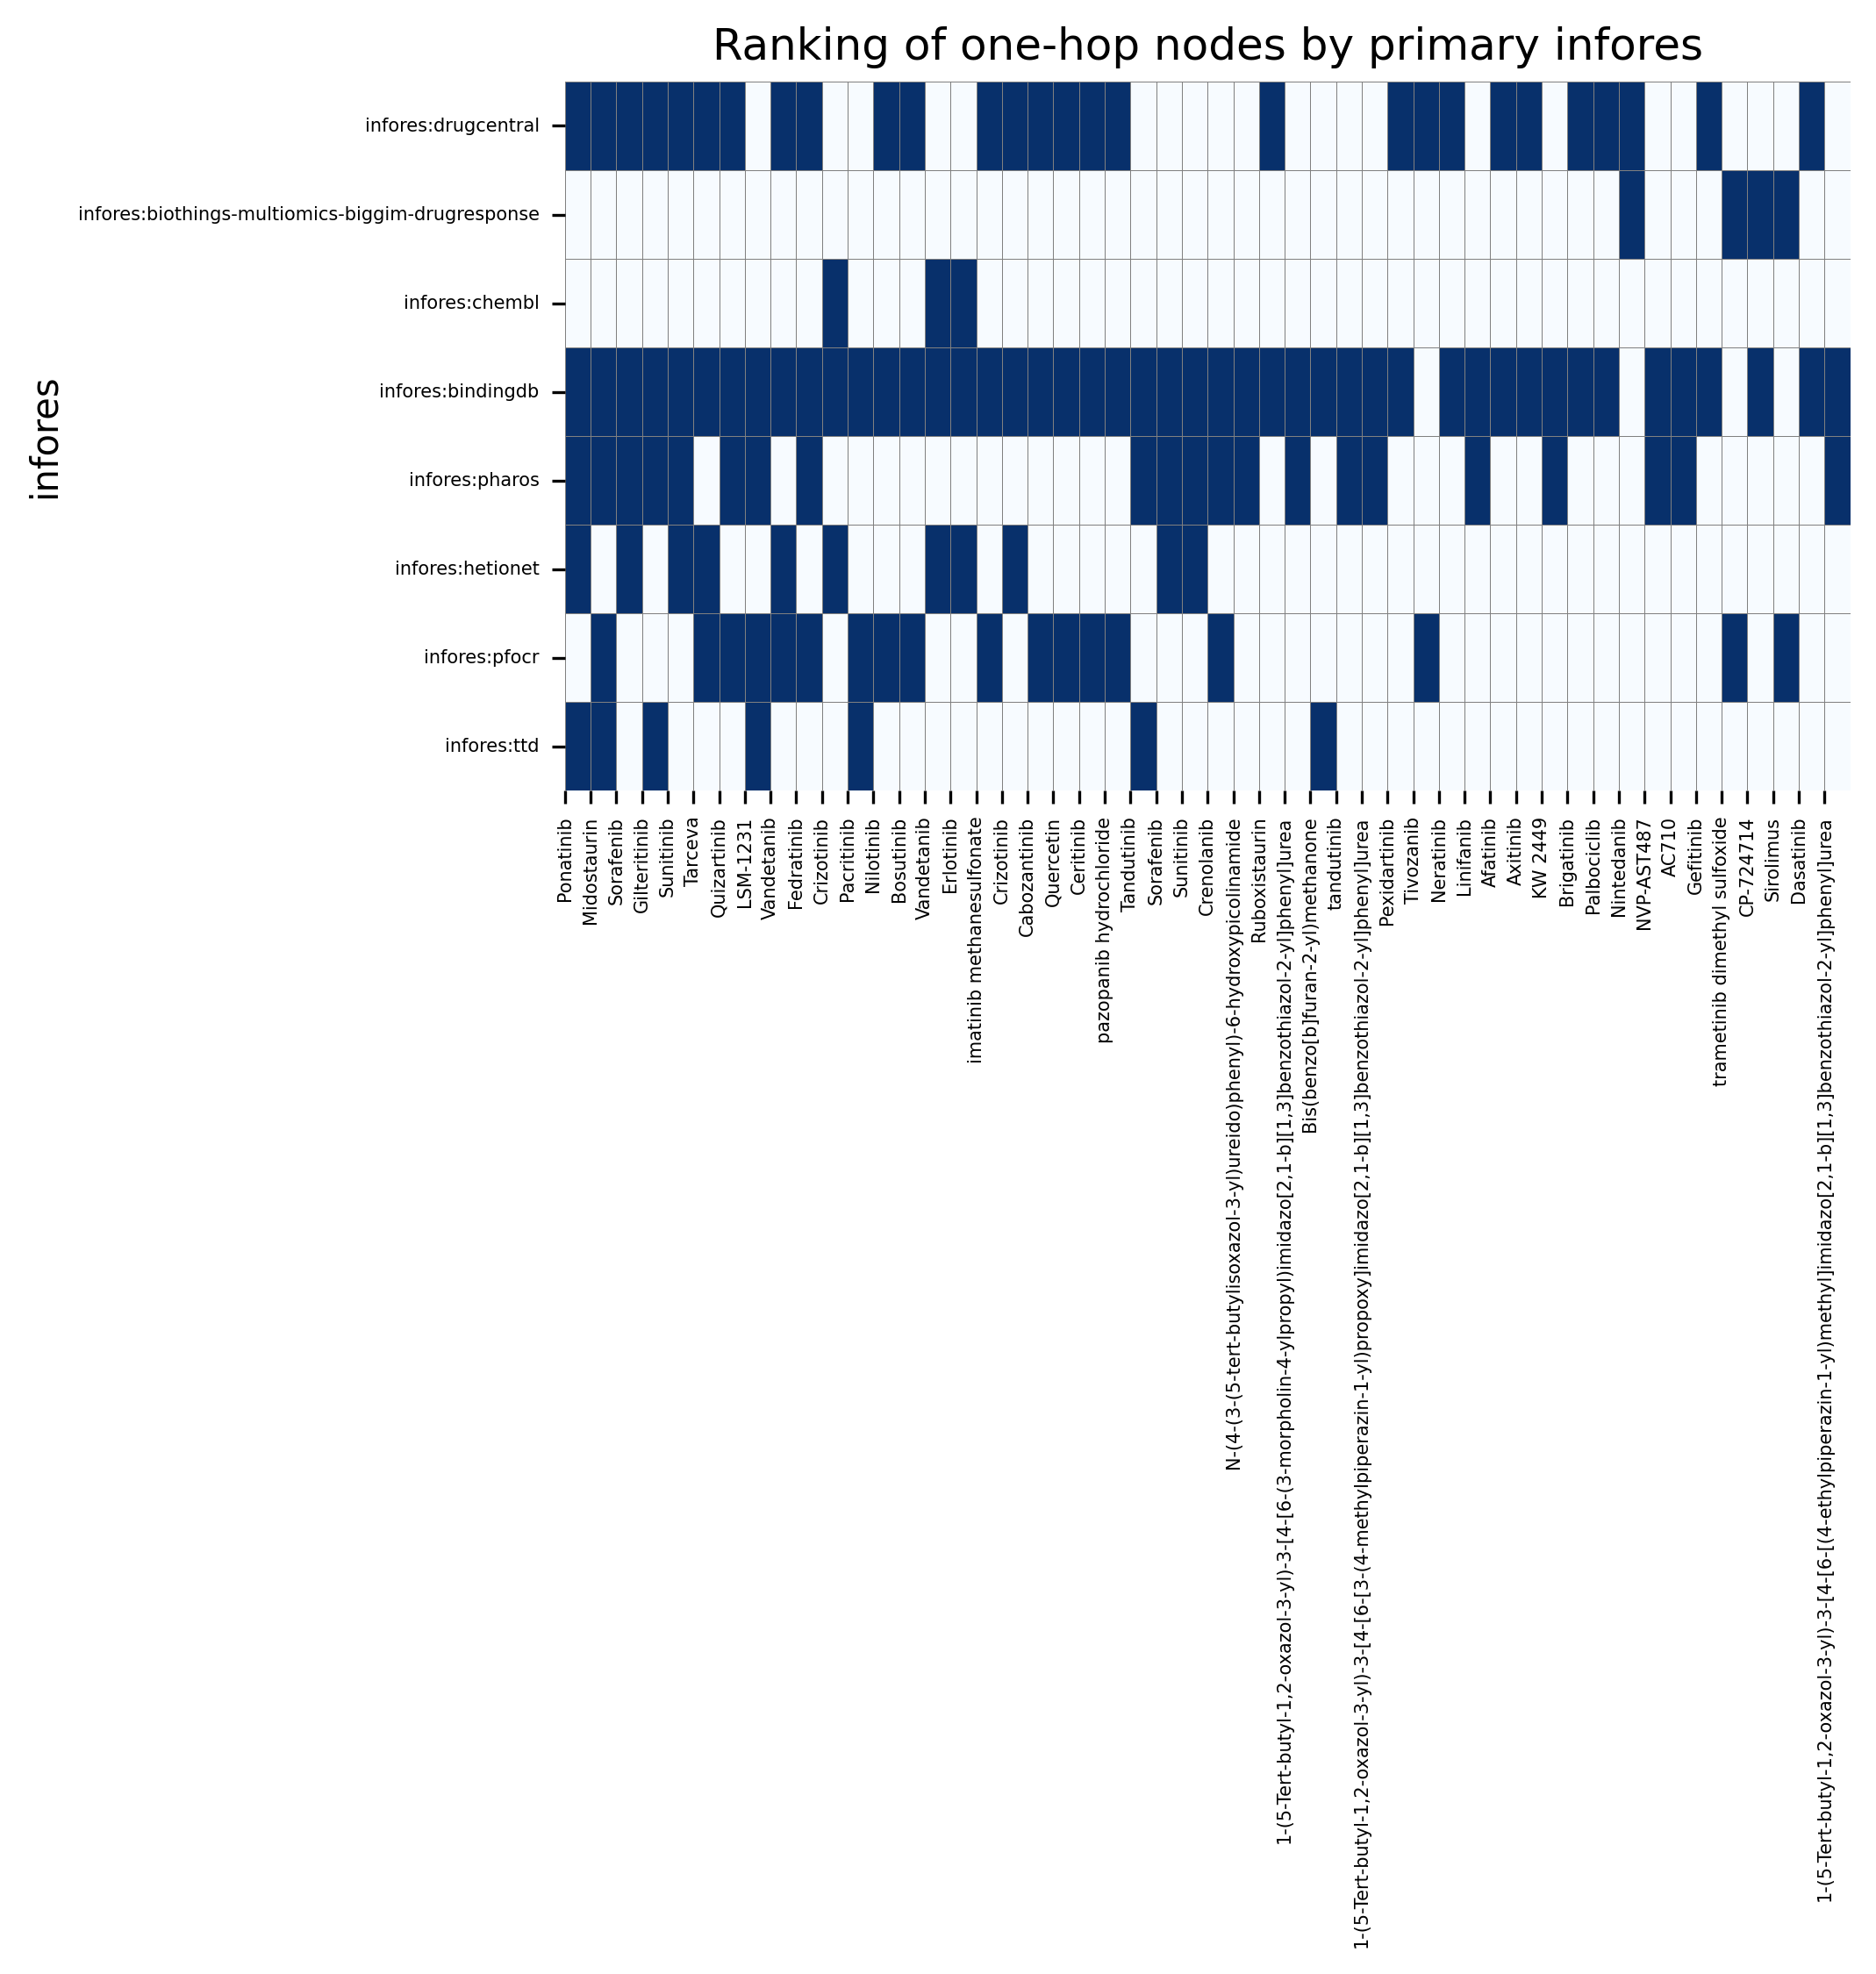

[Text(0.5, 0, 'Ponatinib'), Text(2.5, 0, 'Sorafenib'), Text(4.5, 0, 'Sunitinib'), Text(6.5, 0, 'Quizartinib'), Text(8.5, 0, 'Vandetanib'), Text(10.5, 0, 'Crizotinib'), Text(12.5, 0, 'Nilotinib'), Text(14.5, 0, 'Vandetanib'), Text(16.5, 0, 'imatinib methanesulfonate'), Text(18.5, 0, 'Cabozantinib'), Text(20.5, 0, 'Ceritinib'), Text(22.5, 0, 'Tandutinib'), Text(24.5, 0, 'Sunitinib'), Text(26.5, 0, 'N-(4-(3-(5-tert-butylisoxazol-3-yl)ureido)phenyl)-6-hydroxypicolinamide'), Text(28.5, 0, '1-(5-Tert-butyl-1,2-oxazol-3-yl)-3-[4-[6-(3-morpholin-4-ylpropyl)imidazo[2,1-b][1,3]benzothiazol-2-yl]phenyl]urea'), Text(30.5, 0, 'tandutinib'), Text(32.5, 0, 'Pexidartinib'), Text(34.5, 0, 'Neratinib'), Text(36.5, 0, 'Afatinib'), Text(38.5, 0, 'KW 2449'), Text(40.5, 0, 'Palbociclib'), Text(42.5, 0, 'NVP-AST487'), Text(44.5, 0, 'Gefitinib'), Text(46.5, 0, 'CP-724714'), Text(48.5, 0, 'Dasatinib')]


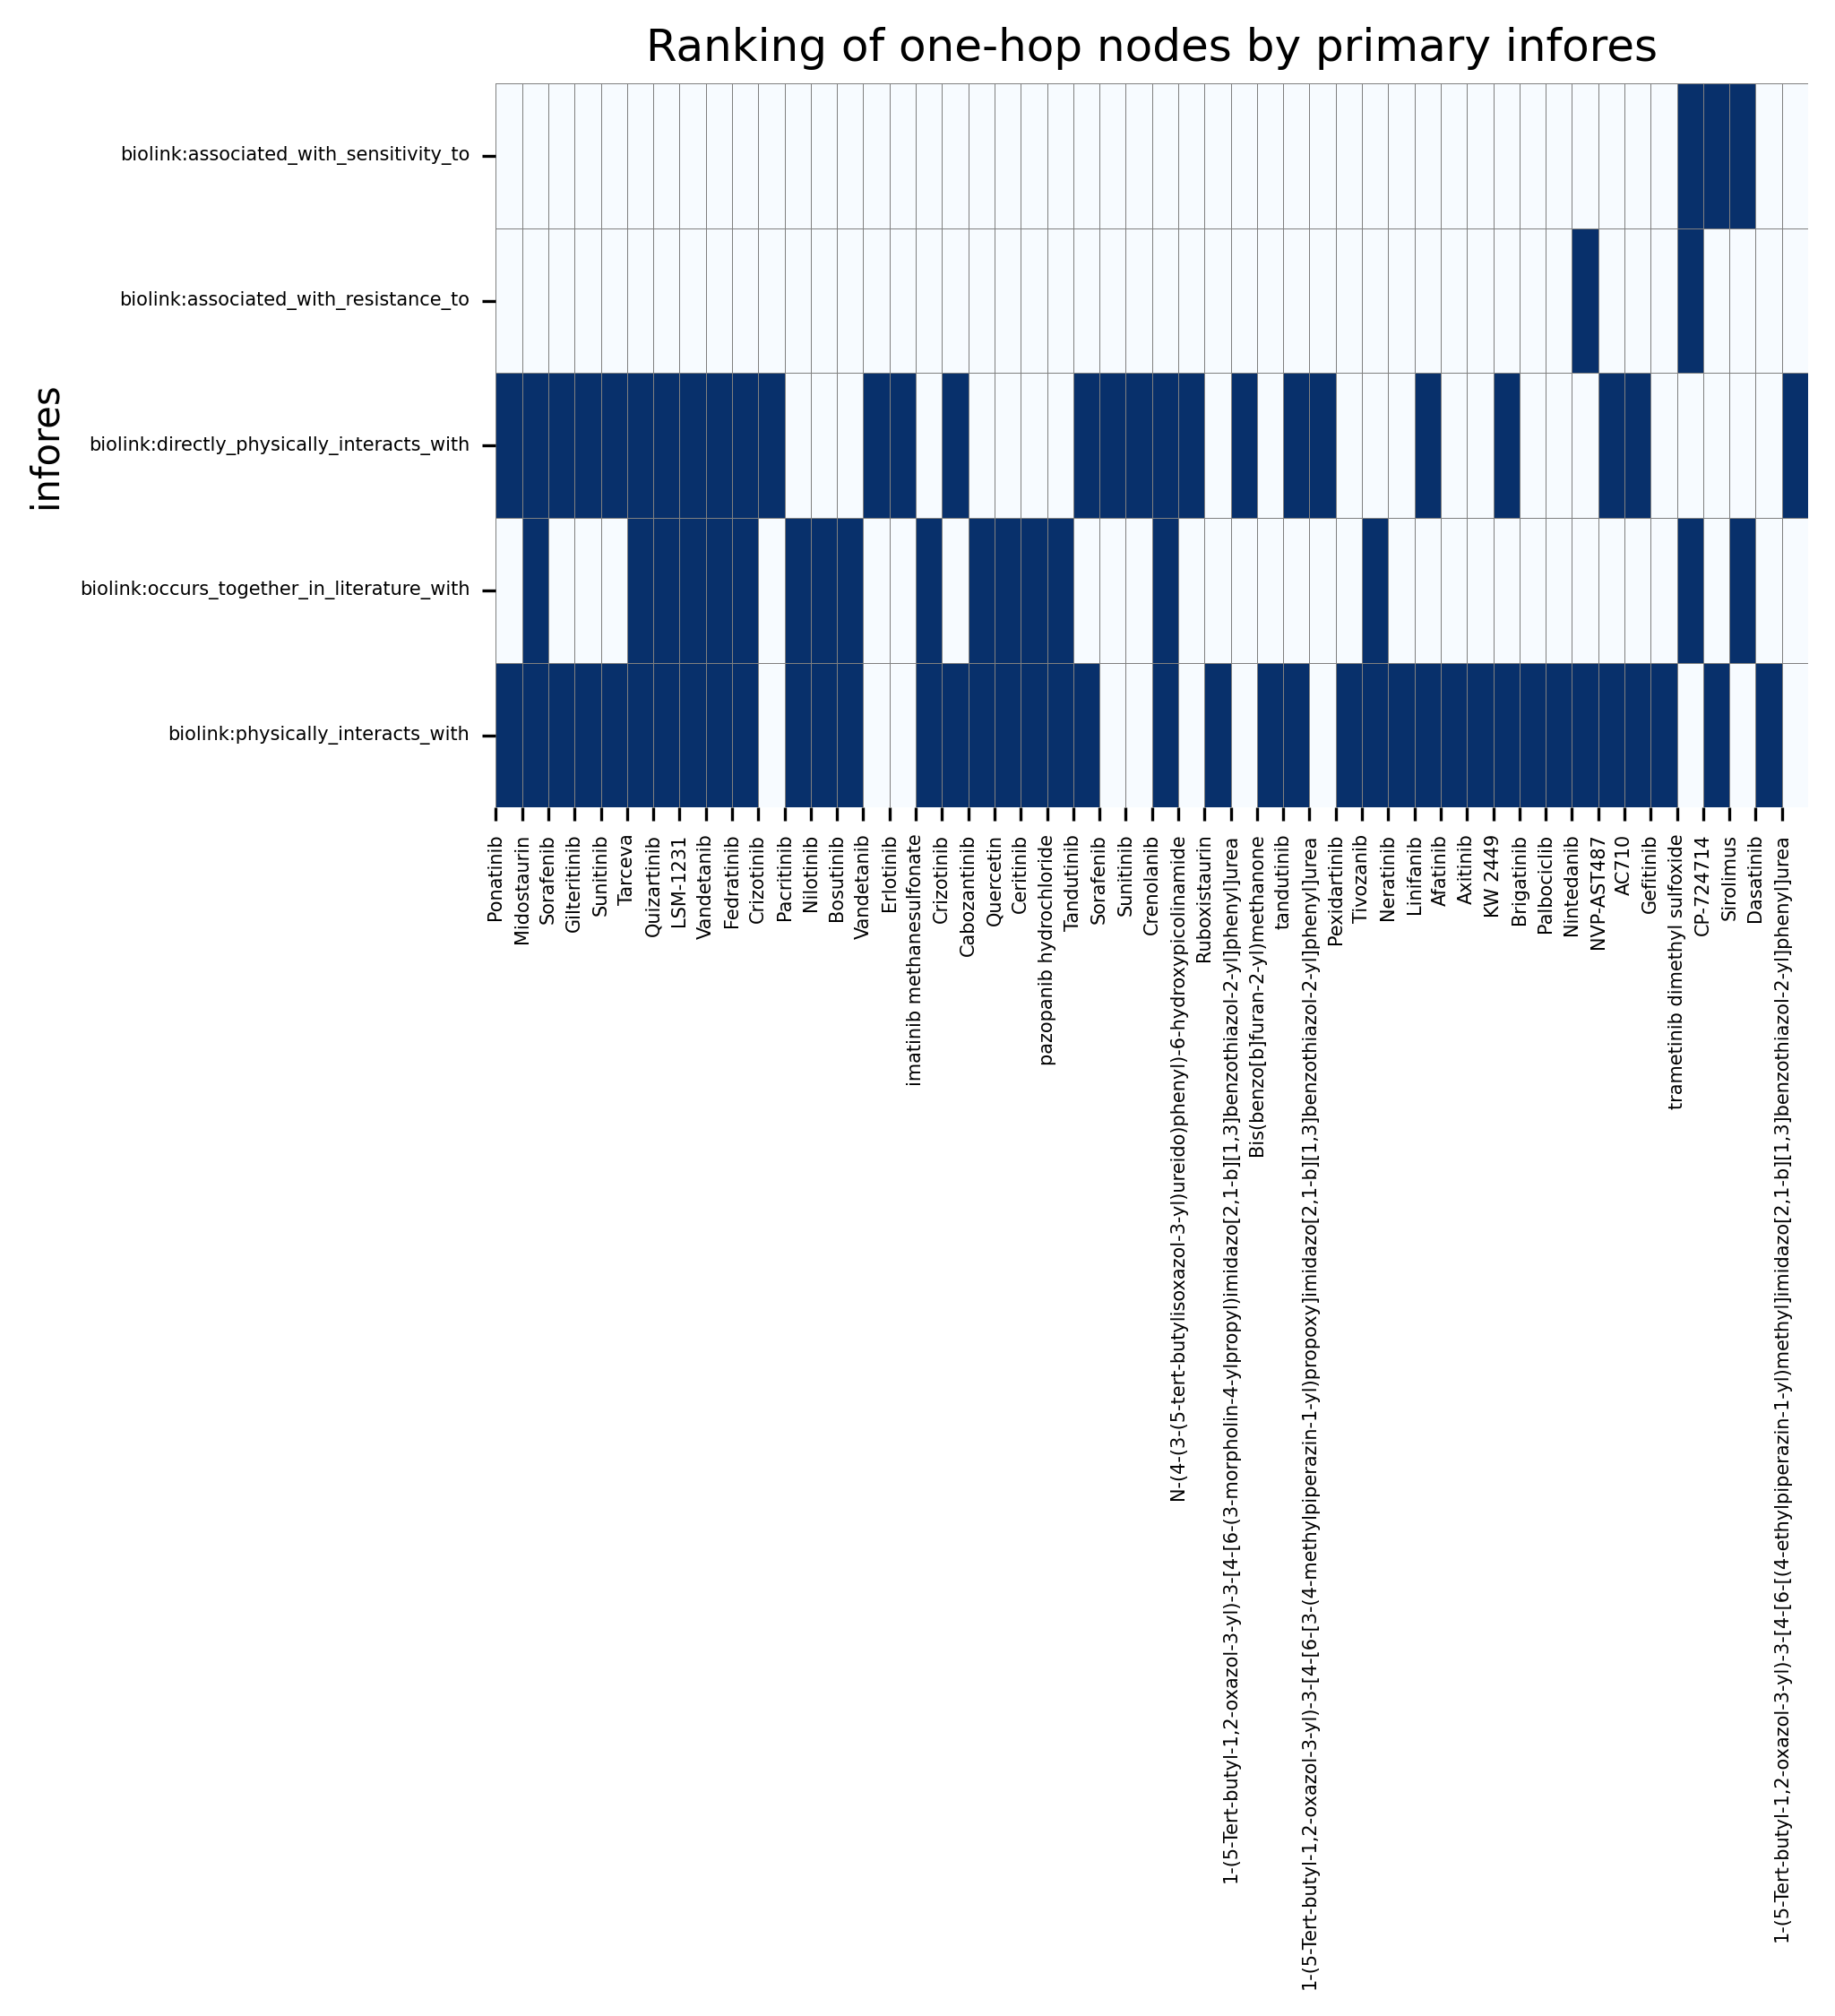

,Ponatinib,Midostaurin,Sorafenib,Gilteritinib,Sunitinib,Tarceva,Quizartinib,LSM-1231,Vandetanib,Fedratinib,...,INCHIKEY:NSLJACGCOKVYOC-AFARHQOCSA-N,INCHIKEY:MQQQNGBBTVKGQZ-AFARHQOCSA-N,INCHIKEY:IDDANJDHVDUCCU-IYARVYRRSA-N,INCHIKEY:GUMGDJDXNYRQLG-KESTWPANSA-N,INCHIKEY:MKUAZUIGYWTRKA-MEMLXQNLSA-N,INCHIKEY:YFUDTXWDELRQKW-HZCBDIJESA-N,INCHIKEY:PSPNRRHQXRHIMO-MXVIHJGJSA-N,INCHIKEY:BXUFOWVQUPXSQM-KESTWPANSA-N,INCHIKEY:MLIBDOUWSPIBHH-QAQDUYKDSA-N,2-(4-fluorophenyl)-N-[[5-[2-(1-methylpyrazol-4-yl)pyridin-4-yl]oxypyridin-2-yl]carbamoyl]acetamide
biolink:associated_with_sensitivity_to,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
biolink:associated_with_resistance_to,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
biolink:directly_physically_interacts_with,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
biolink:occurs_together_in_literature_with,0,1,0,0,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
biolink:physically_interacts_with,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [20]:
# Step 8: Visualize the results
TCT.visulization_one_hop_ranking(result_ranked_by_primary_infores, result_parsed, 
                                num_of_nodes = 50, input_query = input_node1_id, 
                                fontsize = 5)


In [12]:
# End of the example